In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm

In [3]:
def measure_multiple_light_spots(np_array):
    """
    Measure the diameters of multiple light spots in a NumPy array.
    
    Args:
    np_array (np.ndarray): A 2D or 3D NumPy array containing the image data.
    
    Returns:
    diameters (np.ndarray): Array with the diameters of the detected light spots in pixels.
    positions (np.ndarray): Array with the positions in the image of the detected light spots.
    """
    plt.imshow(np_array)
    plt.show()
    try:
        # Convert the NumPy array to grayscale if it's RGB
        if len(np_array.shape) == 3 and np_array.shape[2] == 3:
            gray = cv2.cvtColor(np_array, cv2.COLOR_BGR2GRAY)
        else:
            gray = np_array
        
        # Apply adaptive thresholding
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        plt.imshow(thresh)
        plt.show()
        # Find contours of all light spots
        contours, _ = cv2.findContours(~thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow(thresh)
        plt.show()
        if len(contours) == 0:
            raise ValueError("No light spots detected in the image.")
        
        # List to store diameters
        diameters = []
        positions = []
        
        # Iterate through all contours
        for contour in contours:
            # Calculate the bounding circle of the contour
            (x, y), radius = cv2.minEnclosingCircle(contour)
            
            # Calculate the diameter
            diameter = 2 * radius
            
            # Append the diameter to the list
            diameters.append(diameter)
            positions.append([x,y])
        
        return np.array(diameters), np.array(positions)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

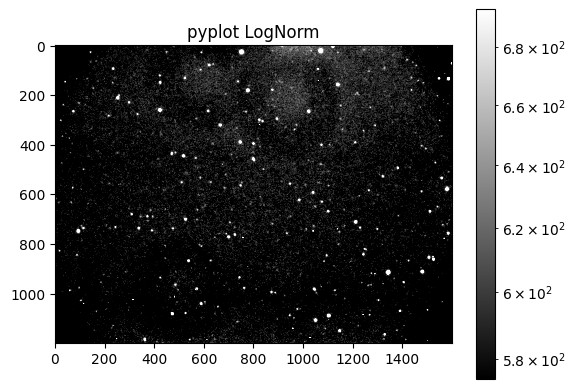

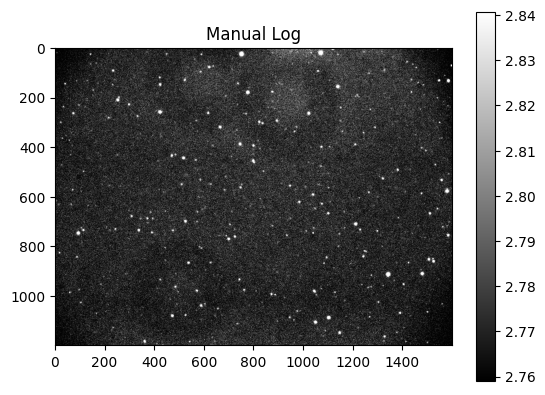

In [4]:
# Open the FITS file
file_path = '111.Altair.fit'
hdul = fits.open(file_path)

# Get the data from the first HDU
image_data = hdul[0].data

# Close the FITS file
hdul.close()

# ============= Plotting the image =============


# Calculate percentiles for more robust limits
vmin, vmax = np.percentile(image_data, (50, 99))

# Plot the image data with logarithmic scale and adjusted contrast
plt.imshow(image_data, cmap='gray', norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.title('pyplot LogNorm')
plt.show()


# ================== Applying log scale to the array itself ==================

# Ensure no negative values for logarithmic transformation
image_data = np.where(image_data > 0, image_data, np.min(image_data))  # Replace 0 or negative values with NaN

# Get indices of pixels that have values less than the range
inds_outs_less = np.where((image_data < vmin))
# Get indices of pixels that have values greater than the range
inds_outs_more = np.where((image_data > vmax))
# Get indices of pixels that have values inside the range
inds_ins = np.where((image_data > vmin) & (image_data < vmax))

# Change the values of the pixels outside the range to the min or max of pixels inside the range
image_data[inds_outs_less] = np.min(image_data[inds_ins])
image_data[inds_outs_more] = np.max(image_data[inds_ins])

# Apply logarithmic scaling
image_data = np.log10(image_data)  # Use natural log (np.log) if preferred

# Normalize to [0,1]
# image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
# image_data = np.log10(image_data)  # Use natural log (np.log) if preferred

# Plot the image data with logarithmic scale and adjusted contrast
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title('Manual Log')
plt.show()


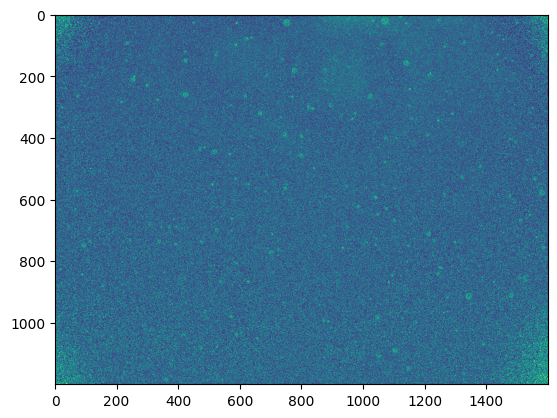

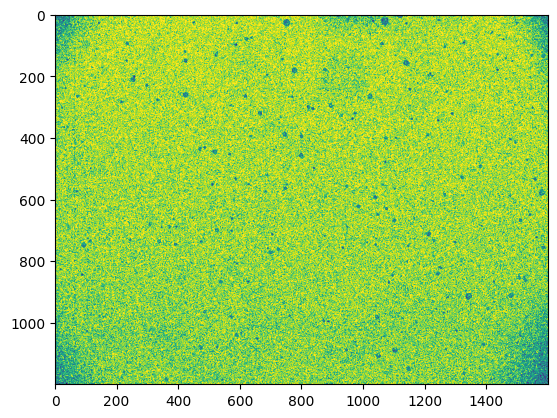

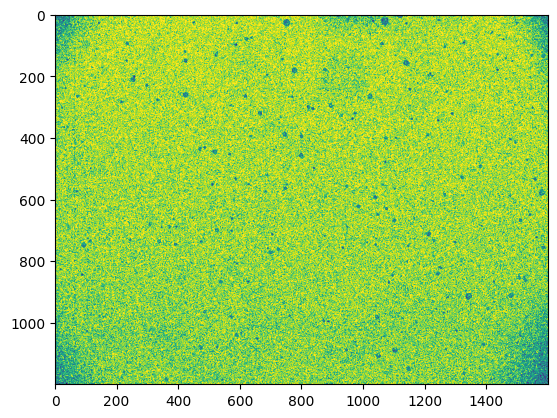

Detected 134577 light spots:


In [5]:
# Open the FITS file
file_path = '111.Altair.fit'
hdul = fits.open(file_path)

# Get the data from the first HDU
image_data_ = hdul[0].data

# Close the FITS file
hdul.close()

# Normaliza la imagen para que los valores estén entre 0 y 255
# img_normalized = cv2.normalize(image_data_, None, 0, 255, cv2.NORM_MINMAX)

# Convierte la imagen normalizada a 8 bits
img_8bit = np.uint8(image_data_)
# img_8bit = np.uint8(img_normalized)

diameters, positions = measure_multiple_light_spots(img_8bit)

if diameters is not None:
    print(f"Detected {len(diameters)} light spots:")
    # for i, diameter in enumerate(diameters, 1):
    #     print(f"Light spot {i}: Diameter ≈ {diameter:.2f} pixels")
else:
    print("Unable to measure the diameters of the light spots.")


Plotting the largest detected spots:

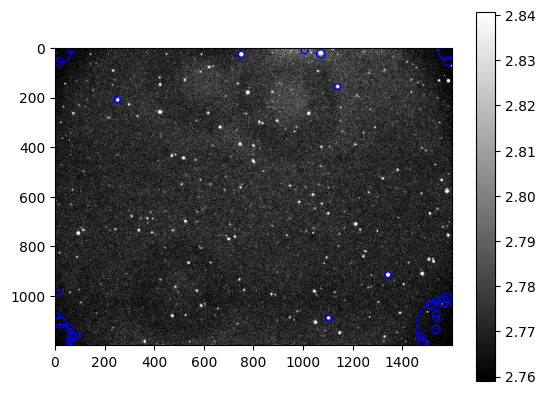

In [6]:
n = 30

# Get the indices of the nth largest detected 'stars'
inds = np.where( np.isin(diameters, np.sort(diameters)[::-1][:n]) )[0]
# Get their radii
rs = diameters[inds]/2
# Get their positions
poss = positions[inds]

fig, ax = plt.subplots()

plt.imshow(image_data, cmap='gray')
# Plot the circles
for s in range(len(rs)):
      circle = plt.Circle((poss[s,0], poss[s,1]), rs[s], color='blue', fill=False)
      ax.add_patch(circle)

plt.colorbar()
plt.show()


Finding density of the spots (to try to get rid of spots that are not stars)

In [7]:
# Get the counts density inside esach of the spots
def get_dens_lum(image, x_center, y_center, radius):
    area = np.pi * radius**2
    values_in_circle = 0
    height, width = image.shape

    for x in range(max(0, x_center - radius), min(width, x_center + radius + 1)):
        for y in range(max(0, y_center - radius), min(height, y_center + radius + 1)):
            if (x - x_center) ** 2 + (y - y_center) ** 2 <= radius ** 2:
                values_in_circle += int(image[y, x])

    return values_in_circle/area


# Get their radii
rs = diameters/2
# Get their positions
poss = positions

# To store the densities of the spots
denss = np.zeros(len(rs))

for i in range(len(rs)):
    x_center, y_center, radius = int(poss[i,0]), int(poss[i,1]), int(rs[i])
    if radius==0:
        denss[i] = 0
        continue
    dens = get_dens_lum(image_data_, x_center, y_center, radius)
    denss[i] = dens

Histogram of the counts density of the spots

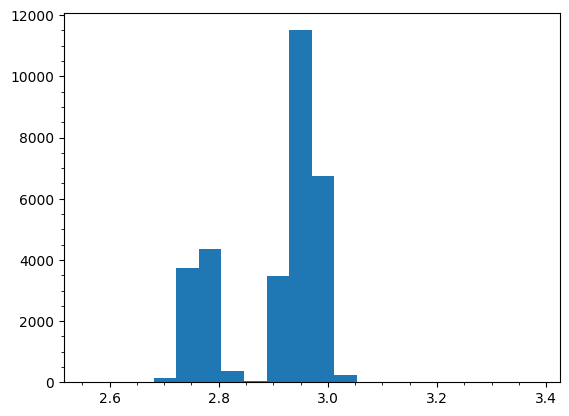

In [8]:
plt.hist(np.log10(denss[np.where(denss!=0)]), bins=20)
plt.minorticks_on()
plt.show()

Plotting the spots in the actual image, with their radii

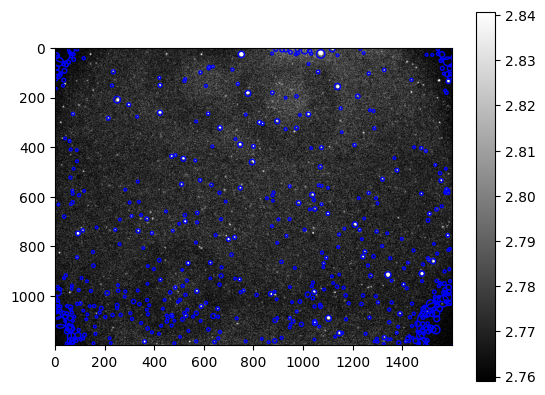

In [9]:
# Get indices for some spots
# Spots with densities greater than some value
inds = np.where( denss > 1 )[0]

# Get their radii
rs = diameters[inds]/2
# Get their positions
poss = positions[inds]

fig, ax = plt.subplots()

plt.imshow(image_data, cmap='gray')
# Plot the circles
for s in range(len(rs)):
      if rs[s] > 5 and rs[s] < 100:
            circle = plt.Circle((poss[s,0], poss[s,1]), rs[s], color='blue', fill=False)
            ax.add_patch(circle)

plt.colorbar()
plt.show()

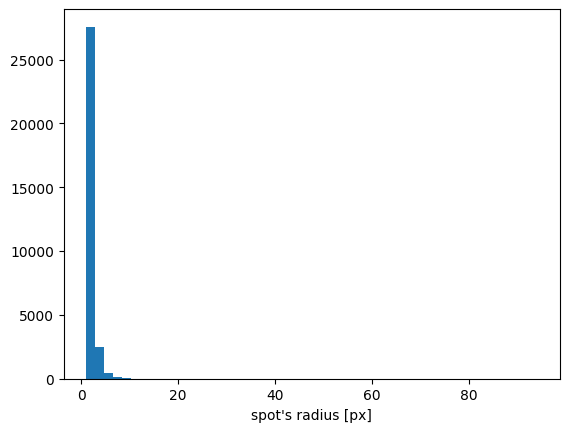

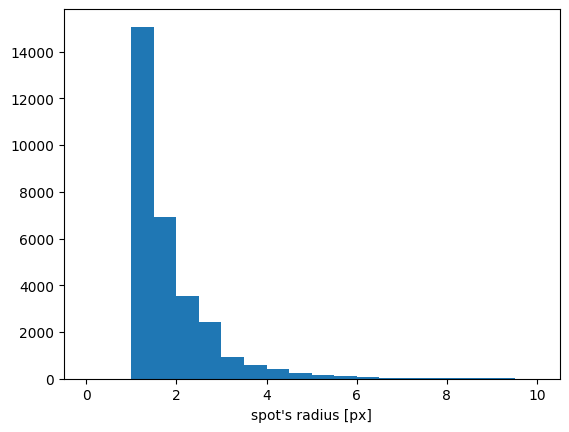

In [11]:
plt.hist(rs, bins=50)
plt.xlabel("spot's radius [px]")
plt.show()

plt.hist(rs, bins=20, range=(0,10))
plt.xlabel("spot's radius [px]")
plt.show()